<a href="https://colab.research.google.com/github/Ekram49/DS-Unit-2-Applied-Modeling/blob/master/Ekram_LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Ekram49/DS-Unit-1-Build/master/ContinousDataset.csv')
df.head()

,Unnamed: 0,Scorecard,Team 1,Team 2,Margin,Ground,Match Date,Winner,Host_Country,Venue_Team1,Venue_Team2,Innings_Team1,Innings_Team2
0,0,ODI # 1,Australia,England,Winner2ndInning,Melbourne,"Jan 5, 1971",Australia,Australia,Home,Away,Second,First
1,1,ODI # 2,England,Australia,Winner2ndInning,Manchester,"Aug 24, 1972",England,England,Home,Away,Second,First
2,2,ODI # 3,England,Australia,Winner2ndInning,Lord's,"Aug 26, 1972",Australia,England,Home,Away,First,Second
3,3,ODI # 4,England,Australia,Winner2ndInning,Birmingham,"Aug 28, 1972",England,England,Home,Away,Second,First
4,4,ODI # 5,New Zealand,Pakistan,Winner1stInning,Christchurch,"Feb 11, 1973",New Zealand,New Zealand,Home,Away,First,Second


In [4]:
df = df.rename(columns={"Team 1": "Team_1", "Team 2": "Team_2",
                   "Team 1": "Team_1","Match Date":"Match_Date"})
df.head()

,Unnamed: 0,Scorecard,Team_1,Team_2,Margin,Ground,Match_Date,Winner,Host_Country,Venue_Team1,Venue_Team2,Innings_Team1,Innings_Team2
0,0,ODI # 1,Australia,England,Winner2ndInning,Melbourne,"Jan 5, 1971",Australia,Australia,Home,Away,Second,First
1,1,ODI # 2,England,Australia,Winner2ndInning,Manchester,"Aug 24, 1972",England,England,Home,Away,Second,First
2,2,ODI # 3,England,Australia,Winner2ndInning,Lord's,"Aug 26, 1972",Australia,England,Home,Away,First,Second
3,3,ODI # 4,England,Australia,Winner2ndInning,Birmingham,"Aug 28, 1972",England,England,Home,Away,Second,First
4,4,ODI # 5,New Zealand,Pakistan,Winner1stInning,Christchurch,"Feb 11, 1973",New Zealand,New Zealand,Home,Away,First,Second


In [5]:
df = df[(((df['Team_1'] == 'India') | (df['Team_2'] == 'India'))) & (((df['Team_1'] == 'Pakistan') | (df['Team_2'] == 'Pakistan'))) ]

df.head()

,Unnamed: 0,Scorecard,Team_1,Team_2,Margin,Ground,Match_Date,Winner,Host_Country,Venue_Team1,Venue_Team2,Innings_Team1,Innings_Team2
50,50,ODI # 54,Pakistan,India,Winner1stInning,Quetta,"Oct 1, 1978",India,Pakistan,Home,Away,Second,First
51,51,ODI # 55,Pakistan,India,Winner2ndInning,Sialkot,"Oct 13, 1978",Pakistan,Pakistan,Home,Away,Second,First
154,155,ODI # 162,Pakistan,India,Winner1stInning,Gujranwala,"Dec 3, 1982",Pakistan,Pakistan,Home,Away,First,Second
155,156,ODI # 163,Pakistan,India,Winner1stInning,Multan,"Dec 17, 1982",Pakistan,Pakistan,Home,Away,First,Second
156,157,ODI # 164,Pakistan,India,Winner1stInning,Lahore,"Dec 31, 1982",India,Pakistan,Home,Away,Second,First


# Baseline

In [6]:
df['Winner'].value_counts(normalize = True)

Pakistan    0.585366
India       0.414634
Name: Winner, dtype: float64

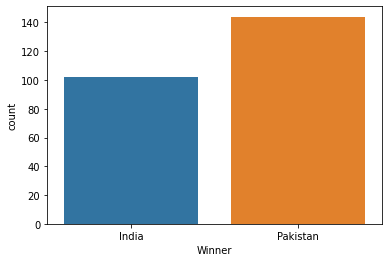

In [7]:
import seaborn as sns
sns.countplot(df['Winner'])

In [8]:
df.isna().sum().sort_values()

Unnamed: 0       0
Scorecard        0
Team_1           0
Team_2           0
Margin           0
Ground           0
Match_Date       0
Winner           0
Venue_Team1      0
Venue_Team2      0
Innings_Team1    0
Innings_Team2    0
Host_Country     8
dtype: int64

In [0]:
df = df.fillna('Missing')

In [10]:
df.isna().sum().sort_values()

Unnamed: 0       0
Scorecard        0
Team_1           0
Team_2           0
Margin           0
Ground           0
Match_Date       0
Winner           0
Host_Country     0
Venue_Team1      0
Venue_Team2      0
Innings_Team1    0
Innings_Team2    0
dtype: int64

# New Features

In [0]:
df['played_at_home'] = (df['Host_Country'] == 'India')

In [0]:
df['played_at_Pakistan'] = (df['Host_Country'] == 'Pakistan')

In [0]:
df['Played_in_neutral'] = (df['Host_Country'] != 'India') & (df['Host_Country'] != 'Pakistan')

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train, test = train_test_split(df, train_size = .8, test_size = .2,
                               stratify = df['Winner'], random_state =42)

In [0]:
train, val = train_test_split(train, train_size = .8, test_size = .2,
                              stratify = train['Winner'], random_state =42)

# Feature selection

In [0]:
target = 'Winner'

In [18]:
train.describe(exclude = 'number').T.sort_values(by = 'unique', ascending = False)

,count,unique,top,freq
Scorecard,156,109,ODI # 1230,2
Match_Date,156,109,"Oct 25, 1991",2
Ground,156,41,Sharjah,29
Host_Country,156,11,India,38
Venue_Team1,156,3,Neutral,94
Venue_Team2,156,3,Neutral,94
Team_1,156,2,India,85
Team_2,156,2,Pakistan,85
Margin,156,2,Winner1stInning,84
Winner,156,2,Pakistan,92


In [0]:
# Removing columns with high cordinality
high_cardinality = 'Scorecard', 'Match_Date'
# Margin will cause data leakage
features = train.columns.drop(['Unnamed: 0', 'Winner', 'Scorecard', 'Match_Date', 'Margin'])

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [21]:
!pip install --upgrade category_encoders

ERROR! Session/line number was not unique in database. History logging moved to new session 60
Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [0]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [25]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)

)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Team_1', 'Team_2', 'Ground',
                                     'Host_Country', 'Venue_Team1',
                                     'Venue_Team2', 'Innings_Team1',
                                     'Innings_Team2'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                      

# Validation accuracy

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
y_pred_val = pipeline.predict(X_val)

In [28]:
accuracy_score(y_val, y_pred_val)

0.6

# Test accuracy

In [0]:
y_pred_test = pipeline.predict(X_test)

In [30]:
accuracy_score(y_test, y_pred_test)

0.56

# PDP

In [0]:
import category_encoders as ce
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [35]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


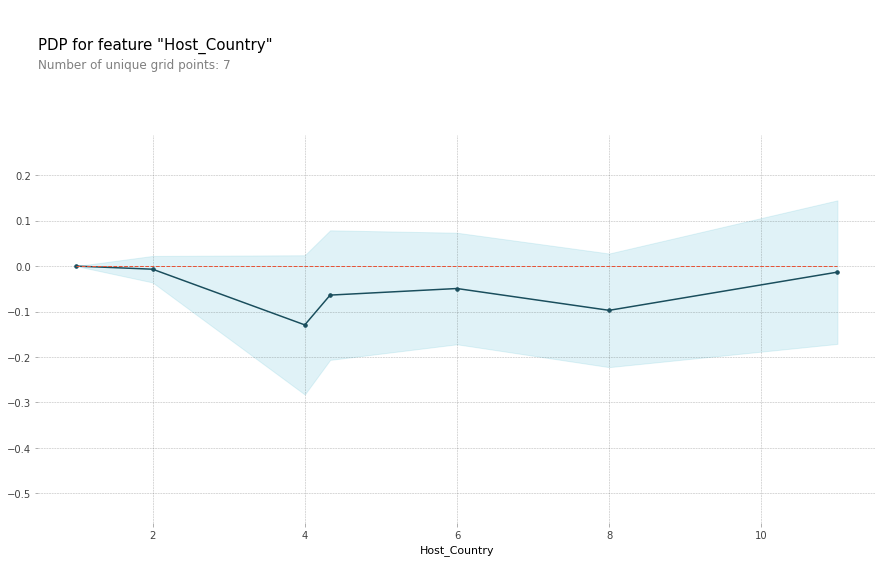

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'Host_Country'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

# With two features

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


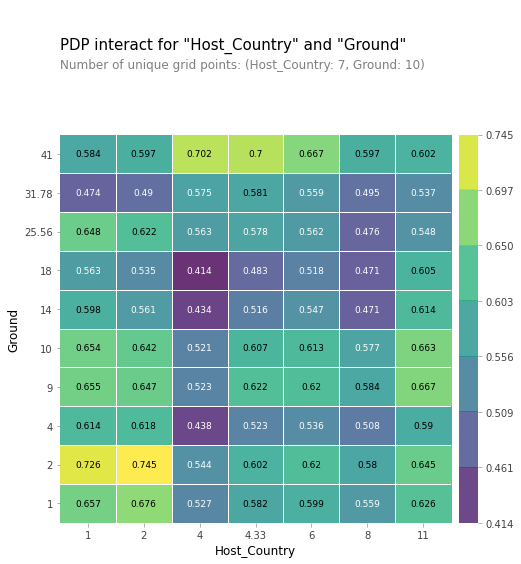

In [39]:
features = ['Host_Country', 'Ground']

interaction = pdp_interact(
    model=model, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);